# Module 4. Compile the pretrained PyTorch model with SageMaker Neo
---

In this notebook, we compile and deploy the model trained in the previous session with SageMaker Neo. SageMaker Neo is an API that optimizes machine learning models for hardware, and models compiled with Neo can run anywhere in the cloud and on edge devices.

As of August 2021, SageMaker Neo supports PyTorch 1.6.0 on cloud instances and edge devices, and PyTorch 1.5.1 on AWS Inferentia.

Please refer to the link below for instance types, hardware, and deep learning frameworks supported by SageMaker Neo.

- Cloud Instance: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-cloud.html
- Edge Device: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-devices-edge.html


This hands-on can be completed in about **15 minutes to 30 minutes**. 

In [1]:
%load_ext autoreload
%autoreload 2
%store -r
%store

Stored variables and their in-db values:
base_model_name              -> 'mobilenetv2'
bucket                       -> 'sagemaker-us-east-1-454396267554'
classes                      -> ['red_normal', 'brown_normal_korean', 'no_box', 'b
dataset_dir                  -> 'bioplus'
local_model_path             -> '/opt/ml/model'
model_name                   -> 'model_best.pth'
num_classes                  -> 7
raw_dir                      -> 'raw'


In [2]:
try:
    base_model_name
    local_model_path
    model_name
    num_classes
    print("[OK] You can proceed.")
except NameError:
    print("+"*60)
    print("[ERROR] Please run previous notebooks and before you continue.")
    print("+"*60)

[OK] You can proceed.


In [3]:
import logging, sys
def _get_logger():
    '''
    로깅을 위해 파이썬 로거를 사용
    # https://stackoverflow.com/questions/17745914/python-logging-module-is-printing-lines-multiple-times
    '''
    loglevel = logging.DEBUG
    l = logging.getLogger(__name__)
    if not l.hasHandlers():
        l.setLevel(loglevel)
        logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))        
        l.handler_set = True
    return l  

logger = _get_logger()


In [4]:
import os, sys, sagemaker
sys.path.insert(0, "./src")
#!{sys.executable} -m pip install -qU "sagemaker>=2.45"
print(sagemaker.__version__)
model_trace_name = 'model.pth'

2.45.0


<br>

# 1. Inference script
---

The code cell below stores the SageMaker inference script in the `src` directory.

In [5]:
%%writefile src/infer_pytorch_neo.py

import io
import json
import logging
import os
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image  # Training container doesn't have this package

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


def model_fn(model_dir):
    import neopytorch

    logger.info("model_fn")
    neopytorch.config(model_dir=model_dir, neo_runtime=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # The compiled model is saved as "compiled.pt"
    model = torch.jit.load(os.path.join(model_dir, "compiled.pt"), map_location=device)

    # It is recommended to run warm-up inference during model load
    sample_input_path = os.path.join(model_dir, "sample_input.pkl")
    with open(sample_input_path, "rb") as input_file:
        model_input = pickle.load(input_file)
    if torch.is_tensor(model_input):
        model_input = model_input.to(device)
        model(model_input)
    elif isinstance(model_input, tuple):
        model_input = (inp.to(device) for inp in model_input if torch.is_tensor(inp))
        model(*model_input)
    else:
        print("Only supports a torch tensor or a tuple of torch tensors")

    return model
    
    
def transform_fn(model, payload, request_content_type='application/octet-stream', 
                 response_content_type='application/json'):

    logger.info('Invoking user-defined transform function')

    if request_content_type != 'application/octet-stream':
        raise RuntimeError(
            'Content type must be application/octet-stream. Provided: {0}'.format(request_content_type))

    # preprocess
    decoded = Image.open(io.BytesIO(payload))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[
                0.485, 0.456, 0.406], std=[
                0.229, 0.224, 0.225]),
    ])
    normalized = preprocess(decoded)
    batchified = normalized.unsqueeze(0)

    # predict
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batchified = batchified.to(device)
    result = model.forward(batchified)

    # Softmax (assumes batch size 1)
    result = np.squeeze(result.detach().cpu().numpy())
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    response_body = json.dumps(result.tolist())

    return response_body, response_content_type

Overwriting src/infer_pytorch_neo.py


<br>

# 2. Load trained model
---

Load the trained model. In order to reduce compatibility issues with different framework versions and issues during serialization, it is recommended to initialize the model structure first and load the model weights rather than loading the entire model as much as possible.

In [6]:
import torch
import torchvision.models as models
import tarfile
import src.train_utils as train_utils

classes, classes_dict = train_utils.get_classes(os.path.join(dataset_dir, 'valid'))
num_classes = len(classes)
model = train_utils.initialize_ft_model(base_model_name, num_classes=num_classes, feature_extract=False)

In [7]:
chkpt = torch.load(os.path.join(local_model_path, model_name))
model.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

In [8]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
import torch
import torchvision.models as models
import tarfile

input_shape = [1,3,224,224]
dummy_input = torch.zeros(input_shape).float()
dummy_input = dummy_input.to(device)
trace = torch.jit.trace(model.float().eval(), dummy_input)
trace.save(model_trace_name)

## Local Inference without Endpoint

Debugging while performing inference in a local environment is recommended because there are many risks to directly deploying a trained model to a production environment without sufficient testing. Please refer to the code in the code cell below as an example.

In [10]:
def get_inference(img_path, predictor, classes_dict, show_img=True):
    with open(img_path, mode='rb') as file:
        payload = bytearray(file.read())

    response = predictor.predict(payload)
    result = json.loads(response.decode())
    pred_cls_idx, pred_cls_str, prob = parse_result(result, classes_dict, show_img)
    
    return pred_cls_idx, pred_cls_str, prob 

def parse_result(result, classes_dict, show_img=True):
    pred_cls_idx = np.argmax(result)
    pred_cls_str = classes_dict[pred_cls_idx]
    prob = np.amax(result)*100
    
    if show_img:
        import cv2
        import matplotlib.pyplot as plt
        im = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        cv2.putText(im, f'{pred_cls_str} {prob:.2f}%', (10,40), font, 0.7, (255, 255, 0), 2, cv2.LINE_AA)
        plt.figure(figsize=(10, 10))
        plt.imshow(im[:,:,::-1])    

    return pred_cls_idx, pred_cls_str, prob

Once the model deployment is complete, let's do some inference.

In [11]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image
from src.infer_pytorch_neo import transform_fn

model = torch.jit.load(model_trace_name)
model = model.to(device)

path = f"./{dataset_dir}/valid/{classes[0]}"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

Invoking user-defined transform function


(0, 'brown_abnormal_chinese', 99.44975972175598)

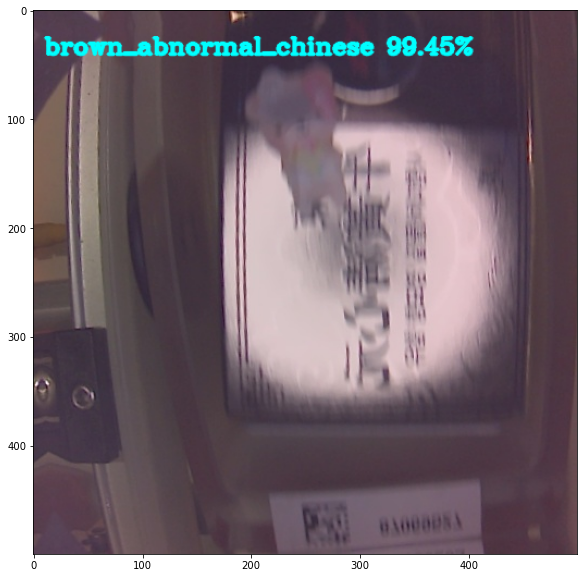

In [12]:
import random
test_idx = random.randint(0, len(img_list))
img_path = img_path_list[test_idx]

with open(img_path, mode='rb') as file:
    payload = bytearray(file.read())
    
response_body, _ = transform_fn(model, payload)
result = json.loads(response_body)
parse_result(result, classes_dict, show_img=True)

<br>

# 3. Compile Model with SageMaker Neo
---

## Model Compression

In [13]:
with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add(model_trace_name)

In [22]:
def compile_model_for_jetson(role, bucket, dataset_dir, 
                             target_device='jetson-nano', trt_ver='7.1.3', cuda_ver='10.2', gpu_code='sm_53',
                             framework='PYTORCH', base_model_name='model', img_size=224, use_gpu=True):
    import time
    import sagemaker
    from sagemaker.utils import name_from_base
    sm_client = boto3.client('sagemaker')
    sess = sagemaker.Session()
    region = sess.boto_region_name
    target_device_ = target_device.replace('_', '-')

    if use_gpu:
        compilation_job_name = name_from_base(f'{target_device_}-{base_model_name}-gpu-pytorch')
    else:
        compilation_job_name = name_from_base(f'{target_device_}-{base_model_name}-cpu-pytorch')        
    
    s3_compiled_model_path = 's3://{}/{}/{}/neo-output'.format(bucket, dataset_dir, compilation_job_name)
    key_prefix = f'{dataset_dir}/{compilation_job_name}/model'
    s3_model_path = sess.upload_data(path='model.tar.gz', key_prefix=key_prefix)

    # Configuration
    if use_gpu:
        input_config = {
            'S3Uri': s3_model_path,
            'DataInputConfig': f'{{"input0": [1,3,{img_size},{img_size}]}}',
            'Framework': framework,
        }
        output_config = {
            'S3OutputLocation': s3_compiled_model_path,
            'TargetPlatform': { 
                'Os': 'LINUX', 
                'Arch': 'ARM64', # change this to X86_64 if you need
                'Accelerator': 'NVIDIA'  # comment this if you don't have an Nvidia GPU
            },        
            # Jetson Xavier: sm_72; Jetson Nano: sm_53
            'CompilerOptions': f'{{"trt-ver": "{trt_ver}", "cuda-ver": "{cuda_ver}", "gpu-code": "{gpu_code}"}}' # Jetpack 4.5.1            
        }
    else:
        input_config = {
            'S3Uri': s3_model_path,
            'DataInputConfig': f'{{"input0": [1,3,{img_size},{img_size}]}}',
            'Framework': framework,
        }
        output_config = {
            'S3OutputLocation': s3_compiled_model_path,
            'TargetPlatform': { 
                'Os': 'LINUX', 
                'Arch': 'ARM64', # change this to X86_64 if you need
            },        
        }        
        
    # Create Compilation job    
    compilation_response = sm_client.create_compilation_job(
        CompilationJobName=compilation_job_name,
        RoleArn=role,
        InputConfig=input_config,
        OutputConfig=output_config,
        StoppingCondition={ 'MaxRuntimeInSeconds': 900 }
    )
    
    return compilation_response, compilation_job_name, s3_compiled_model_path, s3_model_path

In [16]:
import time, boto3, sagemaker
role = sagemaker.get_execution_role()
bucket = sagemaker.Session().default_bucket()

compilation_cpu_response, compilation_cpu_job_name, s3_cpu_compiled_model_path, s3_cpu_model_path = compile_model_for_jetson(role, bucket, dataset_dir, use_gpu=False)
compilation_gpu_response, compilation_gpu_job_name, s3_gpu_compiled_model_path, s3_gpu_model_path = compile_model_for_jetson(role, bucket, dataset_dir, use_gpu=True)

In [20]:
logger.info(compilation_cpu_response)
logger.info(compilation_gpu_response)

{'CompilationJobArn': 'arn:aws:sagemaker:us-east-1:454396267554:compilation-job/jetson-nano-model-cpu-pytorch-2021-08-13-01-32-54-188', 'ResponseMetadata': {'RequestId': '6300c8e7-f612-4cda-9cda-ada2e2a84408', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '6300c8e7-f612-4cda-9cda-ada2e2a84408', 'content-type': 'application/x-amz-json-1.1', 'content-length': '134', 'date': 'Fri, 13 Aug 2021 01:32:54 GMT'}, 'RetryAttempts': 0}}
{'CompilationJobArn': 'arn:aws:sagemaker:us-east-1:454396267554:compilation-job/jetson-nano-model-gpu-pytorch-2021-08-13-01-32-54-866', 'ResponseMetadata': {'RequestId': '153343c6-702f-428c-a2e1-2d531f858d4b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '153343c6-702f-428c-a2e1-2d531f858d4b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '134', 'date': 'Fri, 13 Aug 2021 01:32:57 GMT'}, 'RetryAttempts': 2}}


In [23]:
sm_client = boto3.client('sagemaker')
compilation_jobs = [compilation_gpu_job_name, compilation_gpu_job_name]

max_time = time.time() + 15*60 # 15 mins
for job in compilation_jobs:
    while time.time() < max_time:
        resp = sm_client.describe_compilation_job(CompilationJobName=job)    
        if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
            print('Running...')
        else:
            print(resp['CompilationJobStatus'], job)
            break
        time.sleep(30)

Running...
Running...
Running...
Running...
COMPLETED jetson-nano-model-gpu-pytorch-2021-08-13-01-32-54-866
COMPLETED jetson-nano-model-gpu-pytorch-2021-08-13-01-32-54-866


In [ ]:
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(30)

In [ ]:
# CPU
compilation_job_name = name_from_base(f'{target_device_}-{base_model_name}-cpu-pytorch')
s3_compiled_model_path = 's3://{}/{}/{}/neo-output'.format(bucket, dataset_dir, compilation_job_name)
key_prefix = f'{dataset_dir}/{compilation_job_name}/model'
s3_model_path = sess.upload_data(path='model.tar.gz', key_prefix=key_prefix)

compilation_response = sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': s3_model_path,
        'DataInputConfig': f'{{"input0": [1,3,{img_size},{img_size}]}}',
        'Framework': framework,
        #'FrameworkVersion': framework_version
    },
    OutputConfig={
        'S3OutputLocation': s3_compiled_model_path,
        'TargetPlatform': { 
            'Os': 'LINUX', 
            'Arch': 'ARM64', # change this to X86_64 if you need
        },
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }
)



In [ ]:
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(30)

In [ ]:
neo_ecr_accid = {'us-east-1':'785573368785',
    'us-east-2':'007439368137',
    'us-west-1':'710691900526',
    'us-west-2':'301217895009',
    'ap-northeast-1':'941853720454',
    'ap-northeast-2':'151534178276'
}

ecr_cpu_uri = f'{neo_ecr_accid[region]}.dkr.ecr.{region}.amazonaws.com/sagemaker-inference-pytorch:{framework_version}-cpu-py3'
ecr_gpu_uri = f'{neo_ecr_accid[region]}.dkr.ecr.{region}.amazonaws.com/sagemaker-inference-pytorch:{framework_version}-gpu-py3'

In [ ]:
!cd src && tar -cvzf ../sourcecode.tar.gz .

In [ ]:

s3_src_path = 's3://{}/{}/{}/src/sourcecode.tar.gz'.format(bucket, dataset_dir, compilation_job_name)
print(s3_src_path)

In [ ]:
!aws s3 cp sourcecode.tar.gz {s3_src_path}

In [ ]:
s3_model_path, s3_compiled_model_path, s3_src_path

In [ ]:
deployment_model_name = f'model-{compilation_job_name}'

In [ ]:
compiled_model_path2 = os.path.join(s3_compiled_model_path, 'model-ml_c5.tar.gz')
print(compiled_model_path2)

In [ ]:
# Key
# Value
# MMS_DEFAULT_RESPONSE_TIMEOUT	500
# SAGEMAKER_CONTAINER_LOG_LEVEL	20a
# SAGEMAKER_PROGRAM	infer_pytorch_neo.py
# SAGEMAKER_REGION	us-east-1
# SAGEMAKER_SUBMIT_DIRECTORY	s3://sagemaker-us-east-1-143656149352/sagemaker-inference-pytorch-2021-08-01-09-33-14-680/model.tar.gz

In [ ]:
region

In [ ]:
# create sagemaker model
create_model_api_response = sm_client.create_model(
                                    ModelName=deployment_model_name,
                                    PrimaryContainer={
                                        'Image': ecr_cpu_uri,
                                        'ModelDataUrl': compiled_model_path2,

                                        "Environment": {
                                            "SAGEMAKER_PROGRAM": "infer_pytorch_neo.py",
                                            #"SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/src",
                                            "SAGEMAKER_SUBMIT_DIRECTORY": s3_src_path,
                                            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                                            "SAGEMAKER_REGION": region,
                                            "MMS_DEFAULT_RESPONSE_TIMEOUT": "500"
                                        }                                            
                                    },
                                    ExecutionRoleArn=role
                            )


In [ ]:
compilation_job_name

In [ ]:
endpoint_config_name = f'endpoint-config-ml-c5'

In [ ]:
# create sagemaker endpoint config
instance_type = 'ml.c5.xlarge'
variant_name = 'AllTraffic'
create_endpoint_config_api_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': instance_type,
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': deployment_model_name,
        'VariantName': variant_name
    }]
)

In [ ]:

print ("create_endpoint_config API response", create_endpoint_config_api_response)

In [ ]:
endpoint_name = f'endpoint-ml-c5'
#logger.info(f"Creating endpoint")        
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)


print ("create_endpoint API response", create_endpoint_response)      

In [ ]:
endpoint_info = sm_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_status = endpoint_info['EndpointStatus']
endpoint_status

In [ ]:
# #########################################
# ## endpoint 생성
# #########################################

# if not existing_endpoints:
#     logger.info(f"Creating endpoint")        
#     create_endpoint_response = sagemaker_boto_client.create_endpoint(
#         EndpointName=args.endpoint_name,
#         EndpointConfigName=endpoint_config_name)
# else:
#     logger.info(f"Endpoint exists")            
    

# endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
# endpoint_status = endpoint_info['EndpointStatus']


# logger.info(f'Endpoint status is creating')    
# while endpoint_status == 'Creating':
#     endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
#     endpoint_status = endpoint_info['EndpointStatus']
#     logger.info(f'Endpoint status: {endpoint_status}')
#     if endpoint_status == 'Creating':
#         time.sleep(30)

while endpoint_status == 'Creating':
    endpoint_info = sm_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_status = endpoint_info['EndpointStatus']
    print(f'Endpoint status: {endpoint_status}')
    if endpoint_status == 'Creating':
        time.sleep(30)

In [ ]:

existing_endpoints = sm_client.list_endpoints(NameContains=endpoint_name)['Endpoints']
print(existing_endpoints)

In [ ]:
endpoint_info

In [ ]:
# serializer = sagemaker.serializers.IdentitySerializer(content_type='application/octet-stream')

In [ ]:
# from sagemaker.predictor import Predictor

# sagemaker.serializers.IdentitySerializer(content_type='application/octet-stream')
# #endpoint = 'insert name of your endpoint here'

# # # Read image into memory
# # payload = None
# # with open("image.jpg", 'rb') as f:
# #     payload = f.read()

# # Type:           Predictor
# # String form:    <sagemaker.predictor.Predictor object at 0x7ff780b7de48>
# # File:           ~/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sagemaker/predictor.py
# # Docstring:      Make prediction requests to an Amazon SageMaker endpoint.
# # Init docstring:
# # Initialize a ``Predictor``.

# # Behavior for serialization of input data and deserialization of
# # result data can be configured through initializer arguments. If not
# # specified, a sequence of bytes is expected and the API sends it in the
# # request body without modifications. In response, the API returns the
# # sequence of bytes from the prediction result without any modifications.

# # Args:
# #     endpoint_name (str): Name of the Amazon SageMaker endpoint to which
# #         requests are sent.
# #     sagemaker_session (sagemaker.session.Session): A SageMaker Session
# #         object, used for SageMaker interactions (default: None). If not
# #         specified, one is created using the default AWS configuration
# #         chain.
# #     serializer (:class:`~sagemaker.serializers.BaseSerializer`): A
# #         serializer object, used to encode data for an inference endpoint
# #         (default: :class:`~sagemaker.serializers.IdentitySerializer`).
# #     deserializer (:class:`~sagemaker.deserializers.BaseDeserializer`): A
# #         deserializer object, used to decode data from an inference
# #         endpoint (default: :class:`~sagemaker.deserializers.BytesDeserializer`)
    
# predictor = Predictor(endpoint_name, serializer=serializer)
# inference_response = predictor.predict(data=payload)


In [ ]:
sm_runtime_client = boto3.client('sagemaker-runtime')
response = sm_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/octet-stream',
    Accept='application/json',
    Body=payload
    )

# endpoint_name = model.endpoint_name

# response = runtime_client.invoke_endpoint(
#     EndpointName=endpoint_name, 
#     ContentType='application/x-image',
#     Accept='application/json',
#     Body=img_byte
#     )
# outputs = json.loads(response['Body'].read().decode())

In [ ]:
# payload

In [ ]:
# import time
# import boto3
# import argparse
# import sys, os

# import logging
# import logging.handlers

# def _get_logger():
#     '''
#     로깅을 위해 파이썬 로거를 사용
#     # https://stackoverflow.com/questions/17745914/python-logging-module-is-printing-lines-multiple-times
#     '''
#     loglevel = logging.DEBUG
#     l = logging.getLogger(__name__)
#     if not l.hasHandlers():
#         l.setLevel(loglevel)
#         logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))        
#         l.handler_set = True
#     return l  

# logger = _get_logger()


# #########################################
# ## 커맨드 인자 처리
# #########################################

# # Parse argument variables passed via the DeployModel processing step
# parser = argparse.ArgumentParser()
# parser.add_argument('--model_name', type=str)
# parser.add_argument('--region', type=str, default="ap-northeast-2")
# parser.add_argument('--endpoint_instance_type', type=str, default='ml.t3.medium')
# parser.add_argument('--endpoint_name', type=str)
# args = parser.parse_args()

# logger.info("#############################################")
# logger.info(f"args.model_name: {args.model_name}")
# logger.info(f"args.region: {args.region}")    
# logger.info(f"args.endpoint_instance_type: {args.endpoint_instance_type}")        
# logger.info(f"args.endpoint_name: {args.endpoint_name}")    

# region = args.region
# instance_type = args.endpoint_instance_type
# model_name = args.model_name


# boto3.setup_default_session(region_name=region)
# sagemaker_boto_client = boto3.client('sagemaker')

# #name truncated per sagameker length requirememnts (63 char max)
# endpoint_config_name=f'{args.model_name[:56]}-config'
# existing_configs = sagemaker_boto_client.list_endpoint_configs(NameContains=endpoint_config_name)['EndpointConfigs']

# #########################################
# ## endpoint_config 생성
# #########################################

# if not existing_configs:
#     create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
#         EndpointConfigName=endpoint_config_name,
#         ProductionVariants=[{
#             'InstanceType': instance_type,
#             'InitialVariantWeight': 1,
#             'InitialInstanceCount': 1,
#             'ModelName': model_name,
#             'VariantName': 'AllTraffic'
#         }]
#     )

# existing_endpoints = sagemaker_boto_client.list_endpoints(NameContains=args.endpoint_name)['Endpoints']

# #########################################
# ## endpoint 생성
# #########################################

# if not existing_endpoints:
#     logger.info(f"Creating endpoint")        
#     create_endpoint_response = sagemaker_boto_client.create_endpoint(
#         EndpointName=args.endpoint_name,
#         EndpointConfigName=endpoint_config_name)
# else:
#     logger.info(f"Endpoint exists")            
    

# endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
# endpoint_status = endpoint_info['EndpointStatus']


# logger.info(f'Endpoint status is creating')    
# while endpoint_status == 'Creating':
#     endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
#     endpoint_status = endpoint_info['EndpointStatus']
#     logger.info(f'Endpoint status: {endpoint_status}')
#     if endpoint_status == 'Creating':
#         time.sleep(30)


In [ ]:


# # Create the endpoint configuration 'testEndPointConfig'
# response = client.create_endpoint_config(
#     EndpointConfigName='testEndPointConfig',
#     ProductionVariants=[
#         {
#             'VariantName': 'model1',
#             'ModelName': 'sagemaker-mxnet-2018-10-08-20-54-00-482',
#             'InitialInstanceCount': 1,
#             'InstanceType': 'ml.t2.medium',
#             'InitialVariantWeight': 1
#         },
#         {
#             'VariantName': 'model2',
#             'ModelName': 'sagemaker-mxnet-2018-10-10-20-54-00-482',
#             'InitialInstanceCount': 1,
#             'InstanceType': 'ml.t2.medium',
#             'InitialVariantWeight': 1
#         },
#     ],
#     Tags=[
#         {
#             'Key': 'test_key_ab1',
#             'Value': 'test_value_ab1'
#         },
#     ]
# )

In [ ]:
# while True:
#     resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
#     if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
#         print('Compiling Running...')
#     else:
#         print(resp['CompilationJobStatus'], compilation_job_name)
#         break
#     time.sleep(20)

In [ ]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base


#role = sagemaker.get_execution_role()
role = "arn:aws:iam::143656149352:role/service-role/AmazonSageMaker-ExecutionRole-20210315T163355"
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base(f'Neo-{base_model_name}')
prefix = compilation_job_name + '/model'

s3_model_path = sess.upload_data(path='model.tar.gz', key_prefix=prefix)

data_shape = '{"input0":[1,3,224,224]}'
#target_device = 'ml_c5'
target_device = 'jetson_nano'

framework = 'PYTORCH'
framework_version = '1.6'
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)

In [ ]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker_model = PyTorchModel(model_data=s3_model_path,
                               predictor_cls=Predictor,
                               framework_version=framework_version,
                               role=role,
                               sagemaker_session=sess,
                               source_dir='src',
                               entry_point='infer_pytorch_neo.py',
                               py_version='py3',
                               env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
                              )

## Compile Model

Compile the model with SageMaker Neo. The compiled model is stored in s3 and can be deployed directly to the target edge device or target instance. When deploying to a target edge device, the compiled model can be inferred using the Neo-DLR package. The path to the compiled model artifacts can also be found in the SageMaker UI on the AWS management console and can also be imported as `compiled_model.model_data`.

Reference: https://github.com/neo-ai/neo-ai-dlr

In [ ]:
sagemaker_model.compile

In [ ]:
%%time
compiled_model = sagemaker_model.compile(target_instance_family=target_device, 
                                         input_shape=data_shape,
                                         job_name=compilation_job_name,
                                         role=role,
                                         framework=framework.lower(),
                                         framework_version=framework_version,
                                         output_path=compiled_model_path,
                                         compiler_options="{'gpu-code': 'sm_53', 'trt-ver': '7.1.3', 'cuda-ver': '10.2'}",
                                        )

In [ ]:
s3_neo_model_path = compiled_model.model_data
%store s3_neo_model_path

### Notes

If you have already compiled with SageMaker Neo, you can initialize PyTorch Estimator right away (See code snippets below). Just change the `model_data` argument to the S3 path containing the model artifact compiled with Neo.

```python
compiled_model = PyTorchModel(model_data=compiled_model_path,
                               predictor_cls=Predictor,
                               framework_version = framework_version,
                               role=role,
                               sagemaker_session=sess,
                               source_dir='src',
                               entry_point='infer_pytorch_neo.py',
                               py_version='py3',
                               env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
                              )
```                              

<br>

# 4. (Optional) Deploy Model

---

Deploy the compiled model. It takes about 5-10 minutes to deploy the real-time endpoint, as it provisions the deployment cluster managed by SageMaker and initialize the SageMaker inference container.

## Deploy Model to SageMaker Endpoint

The `deploy(.)` provided by the SageMaker Python API creates `Model, EndpointConfig, and Endpoint` internally. We recommend using the boto3 API for production purposes rather than testing and education purposes.

In [ ]:
compiled_model_path

In [ ]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

compiled_model = PyTorchModel(model_data=f'{compiled_model_path}/model-LINUX_ARM64_NVIDIA.tar.gz',
                               predictor_cls=Predictor,
                               framework_version=framework_version,
                               role=role,
                               sagemaker_session=sess,
                               source_dir='src',
                               entry_point='infer_pytorch_neo.py',
                               py_version='py3',
                               env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
                              )

In [ ]:
%%time
predictor = compiled_model.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.c5.xlarge', wait=False
                                 )
endpoint_name = predictor.endpoint_name

In [ ]:
from IPython.core.display import display, HTML
display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker Endpoint</a> After About 5 Minutes</b>'.format(
            region, endpoint_name
        )
    )
)

## Inference

Once the endpoint is successfully created, let's do some inference.

In [ ]:
import os
import json
import random
import numpy as np
from io import BytesIO
from PIL import Image

path = f"./{dataset_dir}/valid/{classes[0]}"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]
num_imgs = len(img_path_list)

Feel free to change test_idx and test it.

In [ ]:
test_idx = random.randint(0, num_imgs-1)
img_path = img_path_list[test_idx]
pred_cls_idx, pred_cls_str, prob = get_inference(img_path, predictor, classes_dict)

Measures latency for multiple input data. In many cases, performing inference on CPU instances alone is sufficient.

In [ ]:
import time
start = time.time()
for _ in range(100):
    response = predictor.predict(payload)
neo_inference_time = (time.time()-start)
print(f'Neo optimized inference time is {neo_inference_time:.4f} ms')

## Endpoint Clean-up

To prevent billing due to the SageMaker Endpoint, be sure to delete the Endpoint after this Hands-on is over.

In [ ]:
predictor.delete_endpoint()

In [ ]:
# !tar -czvf neo_model.tar.gz neo_model

In [ ]:
# import dlr
# import cv2
# import numpy as np
# from dlr import DLRModel

# def preprocess_image(image):
#     cvimage = cv2.resize(image, (224,224))
#     #config_utils.logger.info("img shape after resize: '{}'.".format(cvimage.shape))

#     img = np.asarray(cvimage, dtype='float32')
#     img /= 255.0 # scale 0 to 1
#     mean = np.array([0.485, 0.456, 0.406]) 
#     std = np.array([0.229, 0.224, 0.225])
#     img = (img - mean) / std
#     img = np.transpose(img, (2,0,1)) 
#     img = np.expand_dims(img, axis=0) # e.g., [1x3x224x224]
#     return img

#     #config_utils.logger.info("img shape final: '{}'.".format(img.shape))

#     #predict(img)
    
# image_data = cv2.imread('raw/red_normal/red_raw_normal_0001.jpeg')
# image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
# image_data = preprocess_image(image_data)

# device = 'cpu'            
# model = DLRModel('neo_model', device)
# model.run(image_data)    

In [ ]:
# image_data = cv2.imread('raw/red_normal/red_raw_normal_0001.jpeg')
# image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
# image_data = preprocess_image(image_data)

# device = 'cpu'            
# model = DLRModel('neo_model', device)
# model.run(img)